In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [ ]:
import os
import cv2
import shutil
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score

import matplotlib.pyplot as plt
plt.style.use('dark_background')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Dataset Preprocessing
In this section, I loaded a dataset containing images of Iranian vehicles. To obtain a more accurate representation of the vehicle objects, I used the YOLOv8n model. I specifically chose the "nano" version because the objects in this dataset—mainly cars and trucks—are simple and clearly identifiable, so a more complex model was unnecessary. Additionally, the nano model provides faster inference.

By applying YOLOv8n to the images, I extracted the bounding boxes of detected objects. I then filtered the results to keep only the bounding boxes related to cars and trucks. From each image, I retained only the largest bounding box to focus on the most prominent vehicle.

Using these bounding boxes, I cropped the images to reduce background noise and emphasize the vehicle area. Finally, I saved the cropped images in a new directory while preserving the original order, resulting in a refined version of the dataset.

In [ ]:
def process_data(image_folder, output_folder, model):
    for folder in os.listdir(image_folder):
        imgs_folder = os.path.join(image_folder, folder)

        for filename in os.listdir(imgs_folder):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(imgs_folder, filename)
                img = cv2.imread(img_path)

                results = model(img)[0]

                boxes = results.boxes
                if boxes is None or boxes.xyxy is None:
                    continue

                car_boxes = []
                for i in range(len(boxes)):
                    cls_id = int(boxes.cls[i])
                    if model.names[cls_id] in ["car", "truck"]:
                        x1, y1, x2, y2 = boxes.xyxy[i].tolist()
                        area = (x2 - x1) * (y2 - y1)
                        car_boxes.append((area, x1, y1, x2, y2))

                if not car_boxes:
                    continue

                _, x1, y1, x2, y2 = max(car_boxes, key=lambda b: b[0])
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

                cropped_car = img[y1:y2, x1:x2]

                save_path = os.path.join(output_folder, folder)
                os.makedirs(save_path, exist_ok=True)
                output_path = os.path.join(save_path, f"{os.path.splitext(filename)[0]}_car.jpg")
                cv2.imwrite(output_path, cropped_car)



model = YOLO("yolov8n.pt")

# train data
train_data_in = "/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/train"
train_data_out = "/kaggle/working/cropped_cars/train/"
process_data(train_data_in, train_data_out, model)

# validation data
val_data_in = "/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/val"
val_data_out = "/kaggle/working/cropped_cars/val/"
process_data(val_data_in, val_data_out, model)

# test data
test_data_in = "/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/test"
test_data_out = "/kaggle/working/cropped_cars/test/"
process_data(test_data_in, test_data_out, model)

zip dataset
shutil.make_archive('/kaggle/working/cropped_cars', 'zip', '/kaggle/working/cropped_cars')

# Loading and Preparing the Dataset
In this step, I extracted the contents of the compressed dataset file (cropped_cars.zip). The extracted dataset was organized into training and validation folders, each containing subdirectories corresponding to class labels.

I then used TensorFlow’s image_dataset_from_directory utility to load both the training and validation datasets. Each image was resized to 128×128 pixels, and the data was loaded in batches of 32, with shuffling enabled to improve model generalization. A fixed seed was used to ensure reproducibility.

To prepare the data for model training, I applied the preprocess_input function to normalize the images according to the requirements of the model architecture being used. The datasets were also prefetched using AUTOTUNE to improve pipeline performance during training.

In [6]:
# Unzip dataset
with zipfile.ZipFile('/content/drive/MyDrive/project/car_model_classification/cropped_cars.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

train_directory = '/content/train/'
train_data = keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    interpolation="bilinear"
)

train_data = train_data.map(
    lambda images, labels: (preprocess_input(images), labels),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)


val_directory = '/content/val/'
val_data = keras.utils.image_dataset_from_directory(
    val_directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    interpolation="bilinear"
)

val_data = val_data.map(
    lambda images, labels: (preprocess_input(images), labels),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

Found 6243 files belonging to 13 classes.
Found 1325 files belonging to 13 classes.


#CBAM (Convolutional Block Attention Module) Implementation
In this section, I implemented the CBAM (Convolutional Block Attention Module), which enhances convolutional neural networks by adaptively refining feature maps using attention mechanisms along two separate dimensions: channel and spatial.

###ChannelAttention:
This module focuses on the importance of each feature channel. It uses both global average pooling and global max pooling to summarize spatial information across each channel. The pooled features are passed through a shared multi-layer perceptron (MLP), and their outputs are combined and passed through a sigmoid activation to generate channel-wise attention weights. These weights are broadcast and multiplied with the input feature map to emphasize the most informative channels.

###SpatialAttention:
This module highlights the most important spatial locations in the feature map. It computes average and maximum values across the channel dimension, concatenates them, and then passes the result through a convolutional layer followed by a sigmoid activation. The resulting spatial attention map is used to refine the input by element-wise multiplication.

###CBAM Layer:
The CBAM class sequentially applies the channel attention followed by the spatial attention to the input feature map. This two-step process allows the model to adaptively focus on the most meaningful features both in terms of channels and spatial locations, leading to better representation learning.

In [7]:
#################################################################################

class ChannelAttention(layers.Layer):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()

        self.shared_mlp = tf.keras.Sequential([
            layers.Dense(in_channels // reduction_ratio, activation='relu', use_bias=False),
            layers.Dense(in_channels, use_bias=False)
        ])

        self.sigmoid = layers.Activation('sigmoid')

    def call(self, inputs):

        avg_pool = self.avg_pool(inputs)
        max_pool = self.max_pool(inputs)

        avg_out = self.shared_mlp(avg_pool)
        max_out = self.shared_mlp(max_pool)

        scale = self.sigmoid(avg_out + max_out)

        scale = tf.expand_dims(tf.expand_dims(scale, 1), 1)  # (B, 1, 1, C)

        return inputs * scale

##################################################################################

class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):

        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)  # (B, H, W, 1)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)   # (B, H, W, 1)

        concat = tf.concat([avg_pool, max_pool], axis=-1)  # (B, H, W, 2)

        attention = self.conv(concat)  # (B, H, W, 1)

        return inputs * attention
##################################################################################

class CBAM(layers.Layer):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()

        self.channel_attention = ChannelAttention(channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def call(self, inputs):

        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x

#Model Initialization
An input layer with shape (128, 128, 3) was defined for RGB images. I used ResNet50 (pre-trained on ImageNet) as a frozen feature extractor. A CBAM module with 2048 channels was added—this number was chosen because the output of ResNet50’s final convolutional block always has 2048 channels.

In [8]:
inputs = layers.Input(shape = (128, 128, 3))

base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))
base_model.trainable = False

cbam = CBAM(channels=2048)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#Bilinear Pooling Layer
A custom BilinearPooling layer was implemented to capture pairwise feature interactions. It takes two input tensors, computes their bilinear outer product, applies signed square-root normalization, and then L2 normalization. The output is a flattened vector of shape (B, C × C), representing rich second-order feature representations.

In [9]:
class BilinearPooling(layers.Layer):
    def __init__(self, **kwargs):
        super(BilinearPooling, self).__init__(**kwargs)

    def call(self, inputs):
        phi_I, x = inputs
        G = tf.matmul(phi_I, x) / tf.cast(tf.shape(x)[1], tf.float32)  # (B, C, C)
        G = tf.sign(G) * tf.sqrt(tf.abs(G) + 1e-10)
        G = tf.nn.l2_normalize(G, axis=[1,2])
        # flatten
        G = tf.reshape(G, [tf.shape(G)[0], -1])  # (B, C*C)
        return G

    def compute_output_shape(self, input_shape):
        # input_shape: [(B, C, N), (B, N, C)]
        batch, C, N = input_shape[0]
        return (batch, C * C)

Bilinear pooling is used to capture second-order feature interactions between two feature maps. Unlike traditional pooling methods, which only capture local information, bilinear pooling aggregates richer information by considering pairwise relationships between features. This method enhances the ability of the model to understand complex patterns by combining two different feature representations. It is particularly useful in tasks that require understanding interactions between different parts of the input, such as fine-grained object recognition or matching tasks.

In [10]:
num_classes = 13

#Model Architecture
In this architecture, I defined the following layers:

###Input Layer:
The input layer is shaped (128, 128, 3) to accept RGB images of size 128×128 pixels.

###Base Model - ResNet50:
I used the pre-trained ResNet50 model (with ImageNet weights) as the backbone, excluding the top classification layers. The base model's parameters are frozen to retain the learned features from ImageNet.

###CBAM Attention:
I applied the CBAM (Convolutional Block Attention Module) to the feature map output from ResNet50, refining the feature map by enhancing both channel and spatial importance.

###Bilinear Pooling:
The features were reshaped and permuted before applying the BilinearPooling layer. This layer captures pairwise feature interactions by computing the bilinear product of the features, enhancing the model's representation power.

###Output Layer:
The final dense layer uses a softmax activation function to output the class probabilities.

In [11]:
inputs = layers.Input(shape=(128, 128, 3))

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False

feature = base_model.output

cbam_feature = CBAM(channels=2048)(feature)

x = layers.Reshape((16, 2048))(cbam_feature)

phi_I = layers.Permute((2, 1))(x)

G = BilinearPooling()([phi_I, x])

outputs = layers.Dense(num_classes, activation='softmax')(G)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return 1e-4

lr_scheduler = LearningRateScheduler(scheduler)

In [13]:
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, batch_size = 32, validation_data = val_data, epochs=5, callbacks=[lr_scheduler])

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2172s 11s/step - accuracy: 0.5542 - loss: 1.5398 - val_accuracy: 0.8294 - val_loss: 0.5860 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1810s 9s/step - accuracy: 0.9090 - loss: 0.3658 - val_accuracy: 0.8642 - val_loss: 0.4406 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1806s 9s/step - accuracy: 0.9834 - loss: 0.1366 - val_accuracy: 0.8823 - val_loss: 0.4019 - learning_rate: 1.0000e-04
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1819s 9s/step - accuracy: 0.9894 - loss: 0.1086 - val_accuracy: 0.8838 - val_loss: 0.3954 - learning_rate: 1.0000e-04
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1810s 9s/step - accuracy: 0.9960 - loss: 0.0922 - val_accuracy: 0.8875 - val_loss: 0.3906 - learning_rate: 1.0000e-04


In [ ]:
model.save("car_fgic.h5")

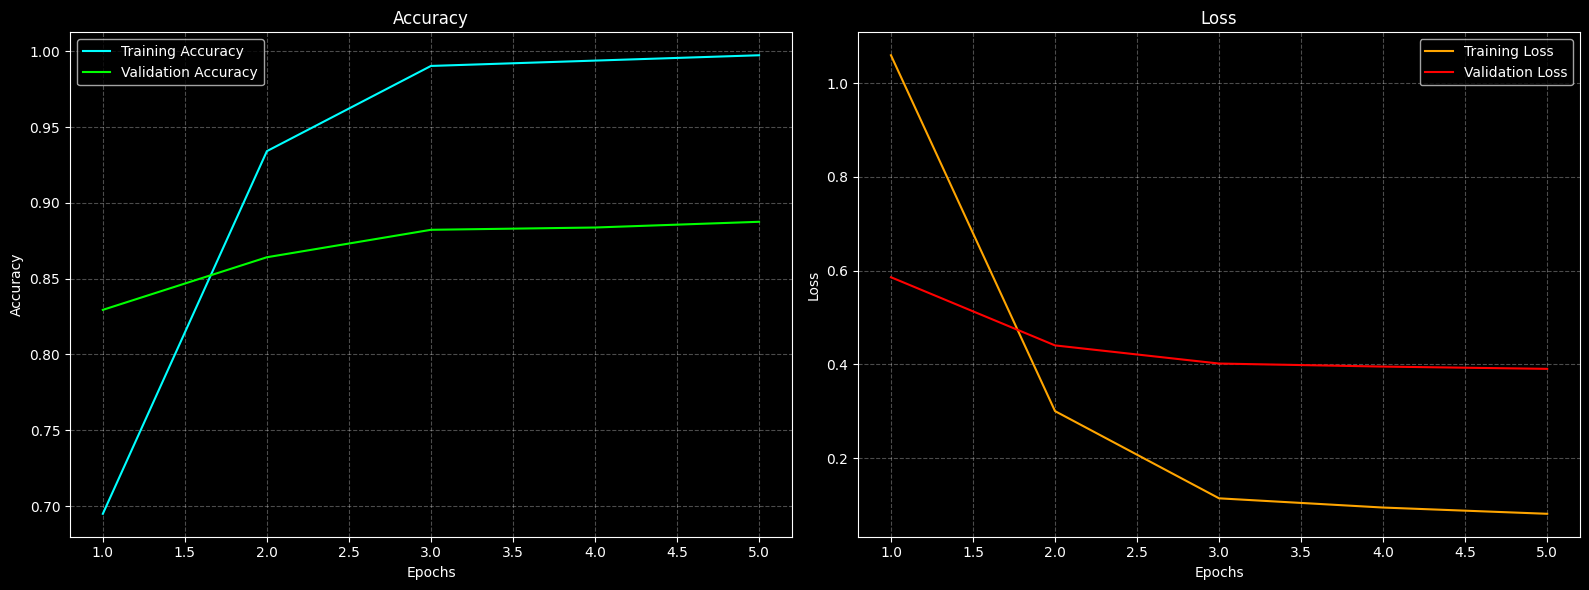

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# accuracy subplot
axs[0].plot(epochs, acc, 'cyan', label='Training Accuracy')
axs[0].plot(epochs, val_acc, 'lime', label='Validation Accuracy')
axs[0].set_title('Accuracy', color='white')
axs[0].set_xlabel('Epochs', color='white')
axs[0].set_ylabel('Accuracy', color='white')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.3)
axs[0].tick_params(colors='white')

# loss subplot
axs[1].plot(epochs, loss, 'orange', label='Training Loss')
axs[1].plot(epochs, val_loss, 'red', label='Validation Loss')
axs[1].set_title('Loss', color='white')
axs[1].set_xlabel('Epochs', color='white')
axs[1].set_ylabel('Loss', color='white')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.3)
axs[1].tick_params(colors='white')

plt.tight_layout()
plt.show()

#Testing the model

In [15]:
test_directory = '/content/test/'
test_data = keras.utils.image_dataset_from_directory(
    test_directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    interpolation="bilinear"
)

test_data = test_data.map(
    lambda images, labels: (preprocess_input(images), labels),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

Found 1323 files belonging to 13 classes.


In [16]:
results = model.evaluate(test_data)
print("Loss:", results[0])
print("Accuracy:", results[1])

42/42 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.8905 - loss: 0.3300
Loss: 0.35058486461639404
Accuracy: 0.8919123411178589


In [17]:
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4

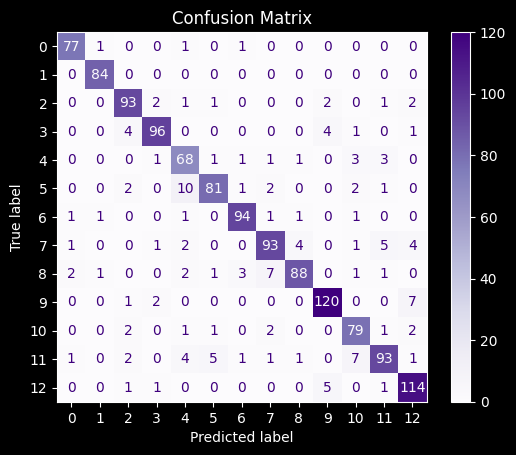


Classification Report:
              precision    recall  f1-score   support

           0     0.9390    0.9625    0.9506        80
           1     0.9655    1.0000    0.9825        84
           2     0.8857    0.9118    0.8986       102
           3     0.9320    0.9057    0.9187       106
           4     0.7556    0.8608    0.8047        79
           5     0.9000    0.8182    0.8571        99
           6     0.9307    0.9400    0.9353       100
           7     0.8692    0.8378    0.8532       111
           8     0.9263    0.8302    0.8756       106
           9     0.9160    0.9231    0.9195       130
          10     0.8316    0.8977    0.8634        88
          11     0.8774    0.8017    0.8378       116
          12     0.8702    0.9344    0.9012       122

    accuracy                         0.8919      1323
   macro avg     0.8922    0.8941    0.8922      1323
weighted avg     0.8935    0.8919    0.8917      1323



In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

In [19]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1_ma = f1_score(y_true, y_pred, average='macro')
f1_mi = f1_score(y_true, y_pred, average='micro')

print(f"Precision(macro): {precision:.4f}")
print(f"Recall(macro):    {recall:.4f}")
print(f"F1 Score(macro):  {f1_ma:.4f}")
print(f"F1 Score(micro):  {f1_mi:.4f}")

Precision(macro): 0.8922
Recall(macro):    0.8941
F1 Score(macro):  0.8922
F1 Score(micro):  0.8919


In [31]:
labels = {0:'Mazda-2000' , 1:'Nissan-Zamiad' , 2:'Peugeot-206' , 3:'Peugeot-207i' ,4:'Peugeot-405' , 5:'Peugeot-Pars' ,
          6:'Peykan' ,7:'Pride-111' ,8:'Pride-131' ,9:'Quik' ,10:'Renault-L90' ,11:'Samand' ,12:'Tiba2' }


0: 480x640 2 persons, 4 cars, 1 stop sign, 221.4ms
Speed: 4.5ms preprocess, 221.4ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


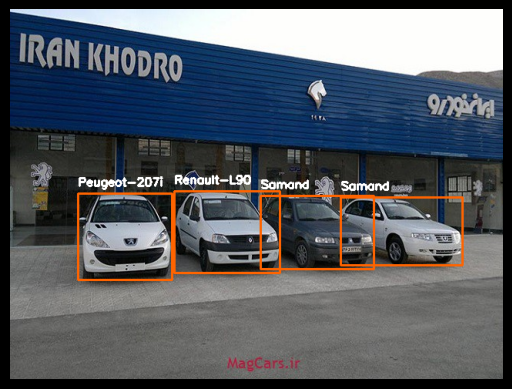

In [48]:
def crop_predict_image(image, car_boxes, classifier_model):
    objects = []
    for car_box in car_boxes:
        x1, y1, x2, y2 = map(int, car_box)
        img = image[y1:y2, x1:x2]
        img = cv2.resize(img, (128, 128))
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        pred = classifier_model.predict(img)
        label = np.argmax(pred)
        objects.append([label, x1, y1, x2, y2])
    return objects

img = cv2.imread("/content/cars.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

yolo = YOLO("yolov8n.pt")
result = yolo(img)[0]
boxes = result.boxes

car_boxes = []
for i in range(len(boxes)):
    cls_id = int(boxes.cls[i])
    if yolo.names[cls_id] in ["car", "truck"]:
        x1, y1, x2, y2 = boxes.xyxy[i].tolist()
        car_boxes.append([x1, y1, x2, y2])


objects = crop_predict_image(img, car_boxes, model)


for o in objects:
    label, x1, y1, x2, y2 = o
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 100, 0), 2)
    img = cv2.putText(img, labels.get(label, 'Unknown'), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
plt.imshow(img)
plt.axis('off')
plt.show()